In [1]:
from kaggle_movie_genres.config import load_config
from kaggle_movie_genres.labelhandler import LabelHandler
from kaggle_movie_genres.featurizer import create_tokenizer_and_embedder
from kaggle_movie_genres.dataloader import create_dataloader
from kaggle_movie_genres.cls_classifier import CLS_Classifier
import logging
logging.basicConfig(level=logging.INFO,    
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S'  # Date + short timestamp
)
logger = logging.getLogger(__name__)
import torch.nn as nn
import torch
import tqdm


### Helper stuff    

In [2]:
# config contains all constants pathes and settings
config = load_config()

# label_handler helps to convert labels between different formats
label_handler = LabelHandler(config)



### Tokenizer, embedder and the model

In [3]:
tokenizer, embedder = create_tokenizer_and_embedder(config)
model = CLS_Classifier(embedder, num_labels=label_handler.get_multi_hot_length(), config=config)

### Create train / validation sets

In [ ]:
train_set, val_set = create_dataloader('data/train.csv', tokenizer, label_handler, config, validation_split=True)
test_set, _ = create_dataloader('data/test.csv', tokenizer, label_handler, config, validation_split=False)

2025-11-12 22:05:11 - INFO - Loaded 8000 records from data/train.csv
2025-11-12 22:05:11 - INFO - Using max token length: 256
2025-11-12 22:05:11 - INFO - Loaded 2000 records from data/test.csv
2025-11-12 22:05:11 - INFO - Using max token length: 256


### Get token frequencies

In [9]:
all_input_tokens_train = []
for batch in train_set:
    features, labels = batch
    all_input_tokens_train.extend(features['input_tokens'].cpu().numpy().flatten().tolist())
    # Forward pass
all_input_tokens_test = []
for (features, _) in test_set:
    all_input_tokens_test.extend(features['input_tokens'].cpu().numpy().flatten().tolist())

In [12]:
import pandas as pd
all_input_tokens_test = pd.DataFrame(all_input_tokens_test, columns=['token_id'])
all_input_tokens_train = pd.DataFrame(all_input_tokens_train, columns=['token_id'])

In [18]:
train_stats = all_input_tokens_train.groupby('token_id').size().reset_index(name='count')
test_stats = all_input_tokens_test.groupby('token_id').size().reset_index(name='count')
token_stats = pd.merge(train_stats, test_stats, on='token_id', how='outer', suffixes=('_train', '_test')).fillna(0)
token_stats

,token_id,count_train,count_test
0,0,1519332.0,380493.0
1,101,8000.0,2000.0
2,102,8000.0,2000.0
3,999,267.0,61.0
4,1000,900.0,227.0
...,...,...,...
19208,29653,1.0,0.0
19209,29656,0.0,1.0
19210,29712,1.0,0.0
19211,30109,1.0,0.0


In [20]:
# calculate deviation between train and test frequencies relative to bigger count
token_stats['deviation'] = (token_stats['count_train'] - token_stats['count_test']).abs() / token_stats[['count_train', 'count_test']].max(axis=1)
token_stats = token_stats.sort_values(by='deviation', ascending=False)
token_stats[token_stats['token_id']>1000]

,token_id,count_train,count_test,deviation
19212,30510,1.0,0.0,1.0
14909,20964,2.0,0.0,1.0
14913,20970,3.0,0.0,1.0
8130,10926,4.0,0.0,1.0
8131,10927,2.0,0.0,1.0
...,...,...,...,...
7476,10108,2.0,2.0,0.0
15225,21485,2.0,2.0,0.0
7460,10091,1.0,1.0,0.0
7445,10076,1.0,1.0,0.0


<Axes: >

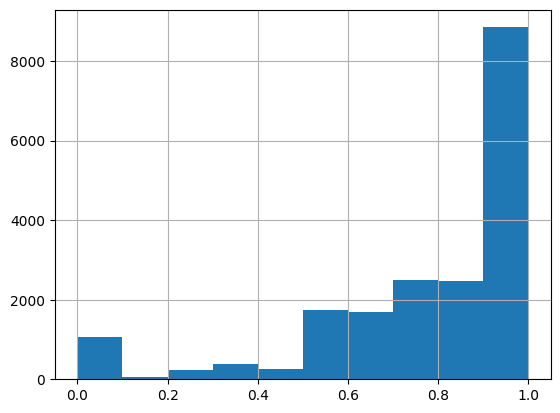

In [21]:
token_stats.deviation.hist()